In [1]:
"""
Produce a CMB map from 4 frequencies (100, 145, 217, 280). 
Foregrounds: 
1. Extragalactic (tSZ, kSZ, CIB) from websky.
2. Extragalctic radio from G15.
##3. Polarised extagalactic = T * pol_fraction fiven in params_ilc_with_simulated_skies.ini (yet to be included).
##4. Galactic foregrounds comes from Caterina Umilta (yet to be included).
Covariance: Computed on the fly from the simulated skies.
"""

'\nProduce a CMB map from 4 frequencies (100, 145, 217, 280). \nForegrounds: \n1. Extragalactic (tSZ, kSZ, CIB) from websky.\n2. Extragalctic radio from G15.\n##3. Polarised extagalactic = T * pol_fraction fiven in params_ilc_with_simulated_skies.ini (yet to be included).\n##4. Galactic foregrounds comes from Caterina Umilta (yet to be included).\nCovariance: Computed on the fly from the simulated skies.\n'

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'
try:
    import os
    rc('text.latex',preamble=r'\usepackage{%s/apjfonts}' %(str(os.getcwd())))
except:
    pass

In [3]:
import argparse, sys, numpy as np, scipy as sc, warnings, os, healpy as H
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/tools/')
#or look into https://github.com/sriniraghunathan/tools
import flatsky, tools, misc
import ilc, foregrounds as fg

import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [4]:
#some constants
h=6.62607004e-34 #Planck constant in m2 kg / s
k_B=1.38064852e-23 #Boltzmann constant in m2 kg s-2 / K-1
Tcmb = 2.73 #Kelvin

In [5]:
#params
paramfile = 'params_ilc_with_simulated_skies.ini'
freqarr = [95, 145, 220, 270]

#S4 atmospheric and instrumental noise values 
#(https://cmb-s4.org/wiki/index.php/Expected_Survey_Performance_for_Science_Forecasting#DSR_Reference_Design)
freqarr = [95, 145, 220, 270]
beamarr= [2.3, 1.5, 1.0, 0.8]
noisearr_T = [2.0, 2.0, 6.9, 16.7]
elkneearr_T = [2154., 4364., 7334., 7308.]
alphakneearr_T = [3.5, 3.5, 3.5, 3.5]
noisearr_P = [2.9, 2.8, 9.8, 23.6]
elkneearr_P = [700., 700., 700., 700.]
alphakneearr_P = [1.4, 1.4, 1.4, 1.4]

#websky foregrounds
websky_folder = 'websky/combined_foreground_maps/'
websky_freq_dic = {95: 100, 145: 145, 220: 217, 270: 280}

freqcalib_fac = None
final_comp = 'CMB'
TParr = ['T']#, 'P']
opbeam = 1.5 #final effective beam for the ILC map
ignore_fg = [final_comp]
verbose = 0
#for plotting
colordic = {95: 'darkblue', 145: 'green', 220: 'goldenrod', 270: 'darkred'}

In [6]:
# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
el = np.arange(param_dict['lmax'])

In [7]:
#collect beam and noise into a dic; elknee and alpha into a dic
beam_noise_dic = {}
elknee_dic = {}
for TP in TParr:
    beam_noise_dic[TP] = {}
    elknee_dic[TP] = {} 
    if TP == 'T':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_T, elkneearr_T, alphakneearr_T
    elif TP == 'P':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_P, elkneearr_P, alphakneearr_P

    for (freq, beam, noise, elknee, alphaknee) in zip(freqarr, beamarr, noisearr, elkneearr, alphakneearr):
        beam_noise_dic[TP][freq] = [beam, noise]
        elknee_dic[TP][freq] = [elknee, alphaknee]

In [8]:
#get beam deconvolved noise nls
nl_dic_beam_deconv = {}
nl_dic = {}
for TP in TParr:
    nl_dic[TP]={}
    nl_dic_beam_deconv[TP]={}    
    for freq in freqarr:
        beamval, noiseval = beam_noise_dic[TP][freq]
        elknee, alphaknee = elknee_dic[TP][freq]

        #nl after deconlving beam for covariance calculation
        nl = misc.get_nl(noiseval, el, beamval, elknee = elknee, alphaknee = alphaknee)
        nl[el<=param_dict['lmin']] = 0.
        nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
        nl_dic_beam_deconv[TP][freq] = nl 

        #nl w/o beam for noise sims
        nl = misc.get_nl(noiseval, el, beamval, elknee = elknee, alphaknee = alphaknee, use_beam_window = 0)
        nl[el<=param_dict['lmin']] = 0.
        nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
        nl_dic[TP][freq] = nl
        
print(nl_dic['T'].keys())

dict_keys([95, 145, 220, 270])


In [9]:
#get beams
bl_dic = misc.get_beam_dic(freqarr, beam_noise_dic['T'], param_dict['lmax'], opbeam = opbeam)
print(bl_dic.keys())
if (0):
    for freq in freqarr:
        plot(bl_dic[freq], color = colordic[freq], label = freq)
    plot(bl_dic['effective'], 'k--', label = r'Effective')
    legend(loc = 1)

dict_keys([95, 145, 220, 270, 'effective'])


In [10]:
#read Cls now
lmax = param_dict['lmax']
camb_file = param_dict['Dlfile_len']
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])
el_camb = el_camb[:lmax]
dl_camb = dl_camb[:lmax]

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

print(len(el_camb))

2500


In [11]:
#foreground only to create Gaussian realisations of radio sky
cl_radio_dic = {}
for freq1 in sorted(freqarr):
    el, cl_radio = fg.get_cl_radio(freq1, freq1, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_rg = param_dict['spec_index_rg'])
    cl_radio = np.concatenate( (np.zeros(param_dict['lmin']), cl_radio) )
    el = np.arange(len(cl_radio))

    cl_radio = cl_radio[:param_dict['lmax']]
    el = el[:param_dict['lmax']]

    cl_radio_dic[freq1] = cl_radio

In [12]:
#create CMB map now
cmb_map = H.synfast(cl_TT, nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
cmb_map_input = np.copy(cmb_map)
#H.mollview(cmb_map, title = r'CMB-only')

create noise maps now
5.39692663852454e-10 35.56294991959947
2.7203824559431116e-09 420.95379073727753
1.7847483590219268e-07 30829.692113001776
1.0328471655328515e-06 178363.3678536457


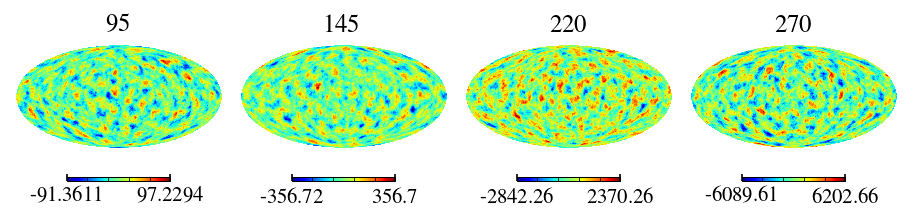

In [13]:
#create noise maps now
print('create noise maps now')
noise_map_dic = {}
for fcnt, freq in enumerate( freqarr ):
    beamval, noiseval = beam_noise_dic['T'][freq]
    print(min(nl_dic['T'][freq]), max(nl_dic['T'][freq]))
    noise_map = H.synfast(nl_dic['T'][freq], nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
    noise_map_dic[freq] = noise_map
    H.mollview(noise_map, title = r'%s' %(freq), sub = (1,4,fcnt+1))

In [14]:
#create radio skies now from SPT-SZ measurements
print('create radio Gaussian skies now from SPT-SZ measurements')
random_seed_fg = abs(int(cmb_map[0]))+1 ##834872
print('Random seed is %s' %(random_seed_fg))
fg_radio_dic = {}
for fcnt, freq in enumerate( freqarr ):
    np.random.seed( random_seed_fg ) #correalted foregrounds
    radio_map = H.synfast(cl_radio_dic[freq], nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
    fg_radio_dic[freq] = radio_map   

create radio Gaussian skies now from SPT-SZ measurements
Random seed is 46


In [15]:
#read websky sims now
print('read websky sims now')
fg_websky_dic = {}
for fcnt, freq in enumerate( freqarr ):
    websky_mapname = '%s/%s.fits' %(websky_folder, websky_freq_dic[freq])
    websky_map = H.read_map(websky_mapname, verbose=verbose)
    if H.get_nside(websky_map) != param_dict['nside']:
        websky_map = H.ud_grade(websky_map, nside_out = param_dict['nside'])
    fg_websky_dic[freq] = websky_map
    #H.mollview(websky_map, title = r'%s' %(freq), sub = (1,4,fcnt+1))

read websky sims now


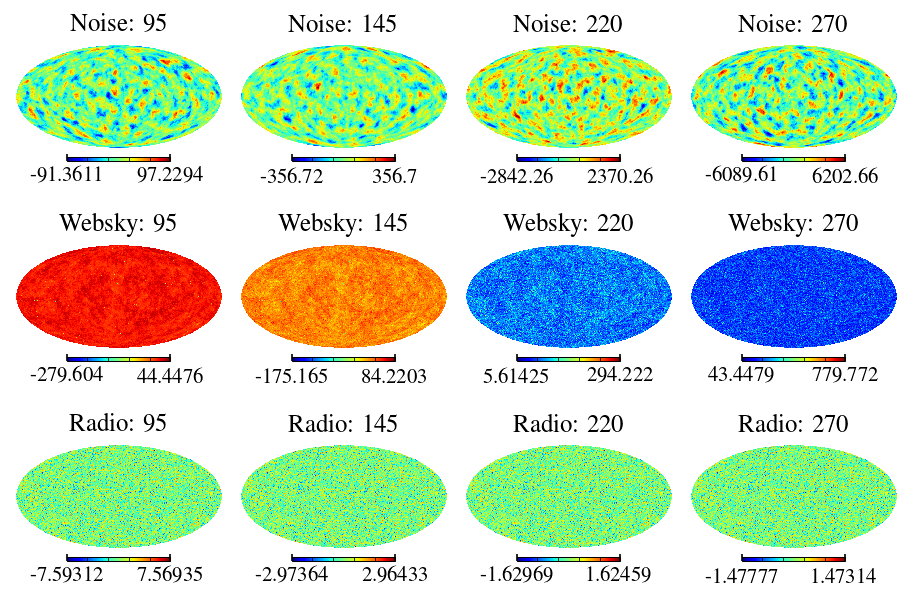

In [16]:
#show maps
vmin, vmax = None, None ##-300, 300.
for fcnt, freq in enumerate( freqarr ):
    H.mollview(noise_map_dic[freq], title = r'Noise: %s' %(freq), sub = (3,4,fcnt+1), min = vmin, max = vmax)
for fcnt, freq in enumerate( freqarr ):
    H.mollview(fg_websky_dic[freq], title = r'Websky: %s' %(freq), sub = (3,4,fcnt+5), min = vmin, max = vmax)
for fcnt, freq in enumerate( freqarr ):
    H.mollview(fg_radio_dic[freq], title = r'Radio: %s' %(freq), sub = (3,4,fcnt+9), min = vmin, max = vmax)
    

In [17]:
#create combined maps now
map_dic = {}
for freq in freqarr:
    #combine CMB and FG
    cmb_fg_map_this_freq = np.copy(cmb_map) + fg_radio_dic[freq] + fg_websky_dic[freq]

    #Smooth
    beamval, noiseval = beam_noise_dic['T'][freq]
    cmb_fg_map_this_freq = H.smoothing(np.copy(cmb_fg_map_this_freq), fwhm = np.radians(beamval/60.), lmax = lmax, verbose = verbose)

    #add noise map to it
    map_dic[freq] = cmb_fg_map_this_freq + noise_map_dic[freq]

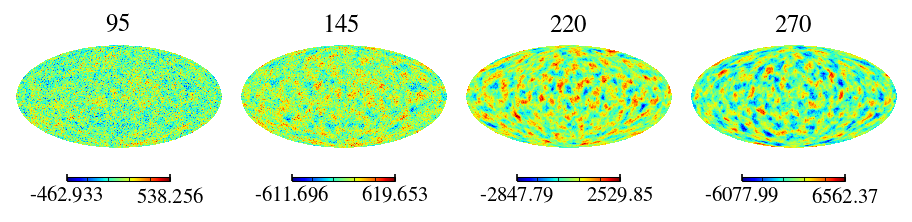

In [18]:
#show maps
for cntr, freq in enumerate( freqarr ):
    H.mollview(map_dic[freq], sub = (1, len(freqarr), cntr + 1), title = freq)

In [19]:
#get map covariance now
el, cl_dic = ilc.get_map_covariance(map_dic, param_dict['lmax'])
print(cl_dic.keys())

Estimating covariance from maps now
(95, 95)
(145, 95)
(220, 95)
(270, 95)
(145, 145)
(220, 145)
(270, 145)
(220, 220)
(270, 220)
(270, 270)
dict_keys([(95, 95), (95, 145), (95, 220), (95, 270), (145, 95), (145, 145), (145, 220), (145, 270), (220, 95), (220, 145), (220, 220), (220, 270), (270, 95), (270, 145), (270, 220), (270, 270)])


2500


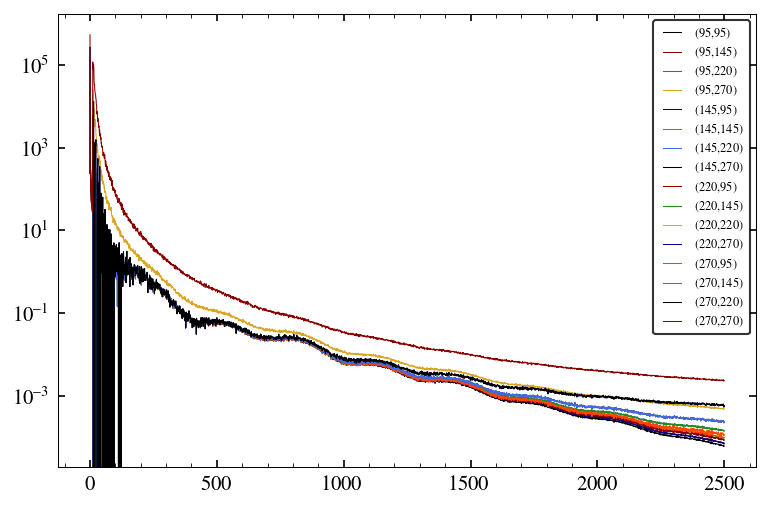

In [20]:
print(len(el))
#plot covariances
for freq1 in freqarr:
    for freq2 in freqarr:
        ax = subplot(1, 1, 1, yscale = 'log')
        plot(el, cl_dic[(freq1, freq2)], label = r'(%s,%s)' %(freq1, freq2), lw = 0.5)
        legend(loc = 1, fancybox  = 1, fontsize = 6)

        '''
        if (freq1, freq2) == (95, 95):
            sbpl = 1
        elif (freq1, freq2) == (145, 145):
            sbpl = 2
        elif (freq1, freq2) == (220, 220):
            sbpl = 3
        elif (freq1, freq2) == (270, 270):
            sbpl = 4
        elif (freq1, freq2) == (145, 95) or (freq1, freq2) == (95, 145):
            sbpl = 5
        elif (freq1, freq2) == (220, 95) or (freq1, freq2) == (95, 220):
            sbpl = 6
        elif (freq1, freq2) == (270, 95) or (freq1, freq2) == (95, 270):
            sbpl = 7
        elif (freq1, freq2) == (220, 145) or (freq1, freq2) == (145, 220):
            sbpl = 9
        elif (freq1, freq2) == (270, 145) or (freq1, freq2) == (145, 270):
            sbpl = 10
        elif (freq1, freq2) == (220, 270) or (freq1, freq2) == (270, 220):
            sbpl = 13
        else:
            continue
        print(freq1, freq2, sbpl)
        ax = subplot(4, 4, sbpl, yscale = 'log')
        plot(el, cl_dic[(freq1, freq2)], label = r'(%s,%s)' %(freq1, freq2), lw = 0.5)
        legend(loc = 1, fancybox  = 1, fontsize = 4)
        '''        

In [21]:
#get ILC map now
ilc_map, weightsarr = ilc.get_ilc_map(final_comp, el, map_dic, bl_dic, param_dict['nside'], param_dict['lmax'], cl_dic = cl_dic, lmin = param_dict['lmin'], estimate_covariance = 1, full_sky = 1)

(-3.0, 3.0)

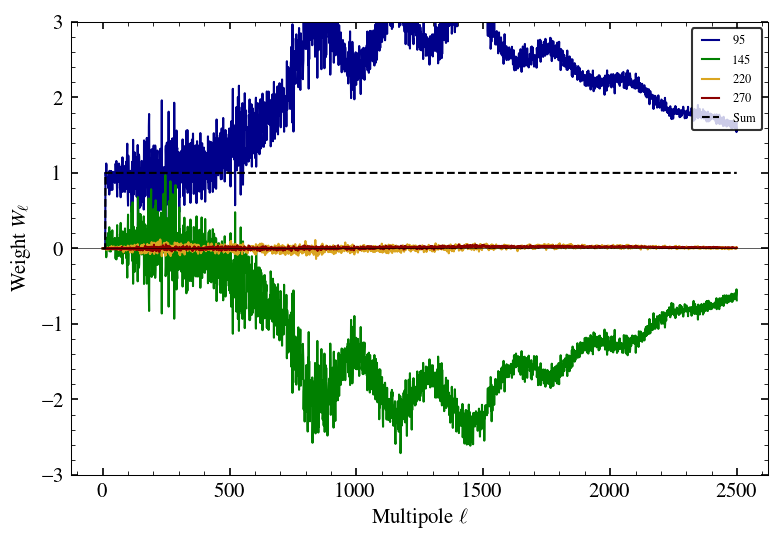

In [22]:
#plot weights now
for frqcntr, freq in enumerate( freqarr ):
    plot(weightsarr[frqcntr], color = colordic[freq], label = r'%s' %(freq))
plot(np.sum(weightsarr, axis = 0), 'k--', label = r'Sum')
axhline(lw=0.3)
legend(loc = 1, fontsize = 6)
xlabel(r'Multipole $\ell$')
ylabel(r'Weight $W_{\ell}$')
ylim(-3., 3.)

In [23]:
'''
#show maps
for cntr, freq in enumerate( freqs ):
    H.mollview(map_dic[freq], sub = (1, 5, cntr + 1), title = freq)    
H.mollview(cmb_map, sub = (1, 5, 4), title = r'Input CMB-only')
H.mollview(ilc_map, sub = (1, 5, 5), title = r'ILC')
#H.mollview(ilc_map, title = r'ILC')
'''

"\n#show maps\nfor cntr, freq in enumerate( freqs ):\n    H.mollview(map_dic[freq], sub = (1, 5, cntr + 1), title = freq)    \nH.mollview(cmb_map, sub = (1, 5, 4), title = r'Input CMB-only')\nH.mollview(ilc_map, sub = (1, 5, 5), title = r'ILC')\n#H.mollview(ilc_map, title = r'ILC')\n"

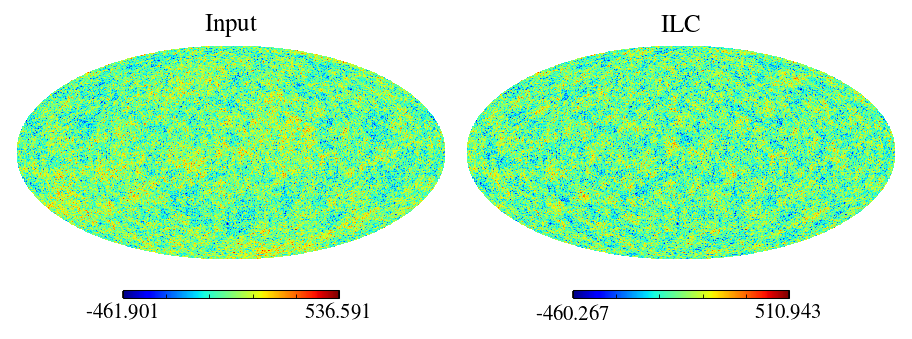

In [24]:
H.mollview(cmb_map_input, sub = (1,2,1), title = r'Input')
H.mollview(ilc_map, sub = (1,2,2), title = r'ILC')

In [25]:
#CMB imput map smoothed
cmb_map_input_smoothed = H.smoothing(np.copy(cmb_map_input), fwhm = np.radians(opbeam/60.), lmax = lmax, verbose = verbose)

In [26]:
#Cls of input and output
Cls_ilc_ori = H.anafast(ilc_map, lmax = lmax)
Cls_150_ori = H.anafast(map_dic[145], lmax = lmax)
Cls_cross_ip_op_ori = H.anafast(cmb_map_input_smoothed, ilc_map, lmax = lmax)

In [27]:
#add beams
Cls_ilc = np.copy(Cls_ilc_ori[:lmax])
Cls_150 = np.copy(Cls_150_ori[:lmax])
Cls_cross_ip_op = np.copy(Cls_cross_ip_op_ori[:lmax])

Cls_ilc = Cls_ilc / bl_dic['effective']**2.
Cls_150 = Cls_150 / bl_dic[145]**2.
Cls_cross_ip_op = Cls_cross_ip_op / bl_dic['effective']**2.

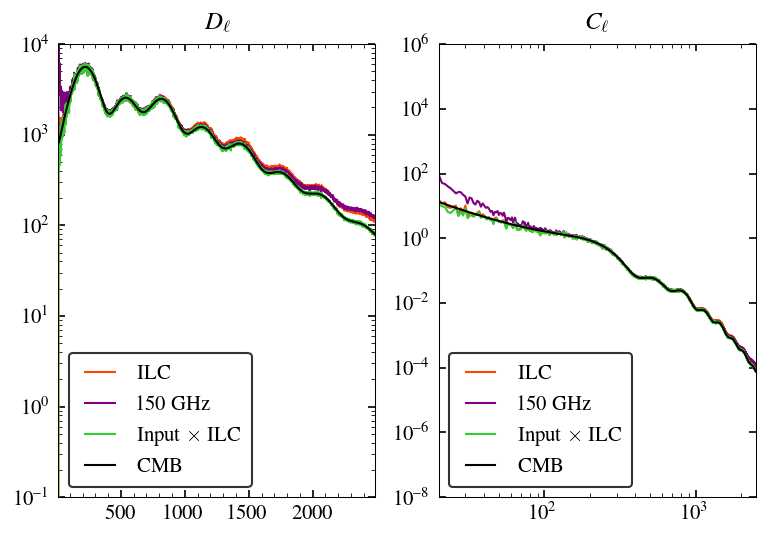

In [29]:
for iter in range(2):
    if iter == 0:
        ax = subplot(1,2,iter+1, yscale = 'log')#, xscale = 'log')
    else:
        ax = subplot(1,2,iter+1, yscale = 'log', xscale = 'log')
    els_ = np.arange(len(Cls_ilc))
    if iter == 0:
        Dls_fac = (els_ * (els_ + 1)) / 2 / np.pi
    else:
        Dls_fac = 1.
    plot(Dls_fac * Cls_ilc, 'orangered', label = r'ILC')
    plot(Dls_fac * Cls_150, 'purple', label = r'150 GHz')
    plot(Dls_fac * Cls_cross_ip_op, 'limegreen', label = r'Input $\times$ ILC')

    if iter == 0:
        Dls_fac = (el_camb * (el_camb + 1)) / 2 / np.pi
    else:
        Dls_fac = 1.
    plot(el_camb, Dls_fac * cl_TT, 'k-', label = r'CMB')

    legend(loc=3)
    if iter == 0:
        title(r'$D_{\ell}$')
        xlim(param_dict['lmin'], param_dict['lmax']-10); ylim(1e-1, 1e4)
    else:
        title(r'$C_{\ell}$')
        xlim(20,lmax);ylim(1e-8,1e6);